In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import logging
import pandas as pd
import gensim
from gensim.models import KeyedVectors

logging.basicConfig(level=logging.INFO, format='%(asctime)-15s %(levelname)s: %(message)s')

In [2]:
# 预训练的词向量文件路径
vec_path = "word2vec.txt"  # 替换为实际路径
# 加载词向量文件
word_vectors = gensim.models.KeyedVectors.load_word2vec_format(vec_path, binary=False)

2025-01-23 06:17:07,940 INFO: loading projection weights from word2vec.txt
2025-01-23 06:17:08,337 INFO: KeyedVectors lifecycle event {'msg': 'loaded (5971, 200) matrix of type float32 from word2vec.txt', 'binary': False, 'encoding': 'utf8', 'datetime': '2025-01-23T06:17:08.337283', 'gensim': '4.3.3', 'python': '3.12.8 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:48:34) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'load_word2vec_format'}


In [3]:
# 获取原始词向量的维度
embedding_dim = word_vectors.vector_size

# 初始化词汇表，包含特殊标记
vocab = {'<unk>': 0, '[PAD]': 1}  # <unk> 和 [PAD] 的索引分别为 0 和 1

# 将原始词向量添加到词汇表中
for idx, word in enumerate(word_vectors.index_to_key, start=len(vocab)):
    vocab[word] = idx

# 更新 word_vectors，确保包含特殊标记
special_tokens = {'<unk>': np.random.uniform(-0.25, 0.25, embedding_dim),
                  '[PAD]': np.zeros(embedding_dim)}

for token, vector in special_tokens.items():
    if token not in word_vectors:
        word_vectors.add_vector(token, vector)

print("Vocabulary size:", len(vocab))

Vocabulary size: 5973


E:\miniconda3\Lib\site-packages\gensim\models\keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


In [4]:
#数据集处理
class TextDataset(Dataset):
    def __init__(self, texts, labels, word_vectors, max_len, unk_token='<unk>'):
        """
        文本数据集类
        :param texts: 文本数据列表，每个元素是一个词索引列表。
        :param labels: 标签列表，与 texts 中的文本一一对应。
        :param word_vectors: 词向量对象，包含词汇表和对应的词向量。
        :param max_len: 每个文本的最大长度，用于填充或截断文本。
        :param unk_token: 未知词标记，默认为 '<unk>'.
        """
        self.labels = labels
        self.word_vectors = word_vectors
        self.unk_token = unk_token
        self.max_len = max_len

        # 确保 <unk> 和 [PAD] 已经存在于 word_vectors 中
        assert '<unk>' in self.word_vectors.key_to_index, "Vocabulary does not contain '<unk>' token."
        assert '[PAD]' in self.word_vectors.key_to_index, "Vocabulary does not contain '[PAD]' token."

        # 填充或截断文本
        self.text = [self.pad_text(text, max_len) for text in texts]

    def pad_text(self, text, max_len):
        """
        填充或截断文本以匹配指定的最大长度
        :param text: 文本数据列表，每个元素是一个词索引列表。
        :param max_len: 每个文本的最大长度，用于填充或截断文本。
        """
        if not isinstance(text, list):
            raise ValueError("Expected a list of integers as input.")

        padded = text[:max_len]  # 截取前 max_len 个元素
        padding_needed = max_len - len(padded)
        if padding_needed > 0:
            padded.extend([self.word_vectors.key_to_index.get('[PAD]', 0)] * padding_needed)  # 使用[PAD]索引填充
        return padded

    def __len__(self):
        """返回数据集中样本的数量"""
        return len(self.labels)

    def __getitem__(self, index):
        """
        获取指定索引的数据
        :param index: 数据索引。
        :return: 一个元组，包含文本数据和对应的标签。
        """
        text_tensor = torch.tensor(self.text[index], dtype=torch.long)  # 只传递词索引
        label_tensor = torch.tensor(self.labels[index], dtype=torch.long)
        return text_tensor, label_tensor

In [22]:
class TextCNN(nn.Module):
    def __init__(self,vocab_size,embedding_dim,num_filters,filter_sizes,num_classes,dropout):
        """
        文本分类模型
        :param vocab_size: 词汇表大小。
        :param embedding_dim: 嵌入维度。
        :param num_filters: 卷积核数量。
        :param filter_sizes: 卷积核大小列表。
        :param num_classes: 分类类别数量。
        :param dropout: 丢弃率。
        """
        super(TextCNN,self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim) # 词嵌入层
         # 卷积层 + 批处理规范化层
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(1, num_filters, (fs, embedding_dim)),
                nn.BatchNorm2d(num_filters),  # 添加批处理规范化层
                nn.ReLU()
            ) for fs in filter_sizes
        ])
        # self.convs = nn.ModuleList([nn.Conv2d(1,num_filters,(fs,embedding_dim)) for fs in filter_sizes]) #卷积层
        self.dropout = nn.Dropout(dropout) #丢弃层
        self.fc = nn.Linear(len(filter_sizes)*num_filters,num_classes) #全连接层

    def forward(self,x):
        """
        前向传播
        :param x: 输入数据，形状为 (batch_size, seq_len)。
        :return: 输出数据，形状为 (batch_size, num_classes)。
        """
        x = self.embedding(x).unsqueeze(1) #形状为 (batch_size, 1, seq_len, embedding_dim)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs] #relu激活函数，形状为 (batch_size, num_filters, seq_len - filter_size + 1)
        x = [F.max_pool1d(i,i.size(2)).squeeze(2) for i in x] #最大池化，形状为 (batch_size, num_filters)
        x = torch.cat(x, 1) #形状为 (batch_size, num_filters * len(filter_sizes))
        x=self.dropout(x) #丢弃层
        logits = self.fc(x) #全连接层
        return logits

In [23]:
def train_model(model,dataloader,criterion,optimizer,num_epochs):
    """
    训练模型
    :param model: 模型。
    :param dataloader: 数据加载器。
    :param criterion: 损失函数。
    :param optimizer: 优化器。
    :param num_epochs: 训练轮数。
    :return: 训练损失列表和准确率列表。
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        logging.info('Epoch {}/{}'.format(epoch+1, num_epochs))
        logging.info('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 训练模式
            else:
                model.eval()   # 评估模式

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad() #梯度清零

                with torch.set_grad_enabled(phase == 'train'): #是否计算梯度
                    outputs = model(inputs) #前向传播
                    _, preds = torch.max(outputs, 1) #预测结果
                    loss = criterion(outputs, labels) #损失函数

                    if phase == 'train':
                        # 手动添加L2正则化损失
                        # l2_loss = 0.0
                        # for param in model.parameters():
                        #     if param.requires_grad:
                        #         l2_loss += torch.norm(param, p=2) ** 2
                        # loss += lambda_l2 * l2_loss / 2

                        loss.backward() #反向传播
                        optimizer.step() #更新参数

                running_loss += loss.item() * inputs.size(0) #损失累加 # 使用 inputs.size(0) 获取批次大小
                running_corrects += torch.sum(preds == labels.data) #正确预测数量累加

            epoch_loss = running_loss / len(dataloader[phase].dataset) #平均损失
            epoch_acc = running_corrects.double() / len(dataloader[phase].dataset) #准确率
            logging.info('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            history[f'{phase}_loss'].append(epoch_loss) #记录损失
    return model, history #返回模型和训练历史

def plot_train_history(history):
    """
    绘制训练和验证损失随时间的变化图
    """
    epochs = range(len(history['train_loss']))

    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.plot(epochs, history['train_loss'],label='train_loss')
    plt.plot(epochs, history['val_loss'], label='val_loss')
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [7]:
#载入数据
data_file = './data/train_set.csv'
data = pd.read_csv(data_file,sep='\t')
labels = data['label'].values
texts = data['text'].values

In [35]:
# 计算文本长度
lengths = [len(text) for text in texts]

# 找出覆盖90%和95%数据所需的最小长度
sorted_lengths = sorted(lengths)
min_length_90 = sorted_lengths[int(0.9 * len(sorted_lengths))]
min_length_95 = sorted_lengths[int(0.95 * len(sorted_lengths))]

print(f"90% of data covered by length: {min_length_90}")
print(f"95% of data covered by length: {min_length_95}")

90% of data covered by length: 8707
95% of data covered by length: 11898


In [8]:
def text_to_int(text, vocab, max_len):
    int_list = [vocab.get(word, vocab['<unk>']) for word in text.split()]
    padded = int_list[:max_len]
    padding_needed = max_len - len(padded)
    if padding_needed > 0:
        padded.extend([vocab['[PAD]']] * padding_needed)
    return padded

In [36]:
#将文本转换为整数列表
texts_as_int_lists = [text_to_int(text, vocab, max_len=11000) for text in texts]

In [37]:
#分割数据集为训练集和验证集
X_train,X_test,y_train,y_test = train_test_split(texts_as_int_lists,labels,test_size=0.2,random_state=42)

#创建数据集对象
train_dataset = TextDataset(X_train,y_train,word_vectors,max_len=11000)
test_dataset = TextDataset(X_test,y_test,word_vectors,max_len=11000)

#创建数据加载器
dataloaders = {
    'train': DataLoader(train_dataset,batch_size=64,shuffle=True),
    'val': DataLoader(test_dataset,batch_size=64,shuffle=False)
}

In [48]:
#初始化模型、损失函数和优化器
model = TextCNN(vocab_size=len(vocab),
                embedding_dim=embedding_dim,
                num_filters=128,
                filter_sizes=[3,4],
                num_classes=14,
                dropout=0.4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001, weight_decay=1e-5)

In [49]:
#开始训练模型
trained_model, history = train_model(model,dataloaders,criterion,optimizer,num_epochs=15)

2025-01-23 09:10:43,516 INFO: Epoch 1/15
2025-01-23 09:10:43,516 INFO: ----------
2025-01-23 09:11:43,714 INFO: train Loss: 0.6583 Acc: 0.8005
2025-01-23 09:11:55,903 INFO: val Loss: 0.2963 Acc: 0.9080
2025-01-23 09:11:55,904 INFO: Epoch 2/15
2025-01-23 09:11:55,904 INFO: ----------
2025-01-23 09:12:56,897 INFO: train Loss: 0.3882 Acc: 0.8825
2025-01-23 09:13:09,633 INFO: val Loss: 0.2591 Acc: 0.9205
2025-01-23 09:13:09,633 INFO: Epoch 3/15
2025-01-23 09:13:09,634 INFO: ----------
2025-01-23 09:14:10,418 INFO: train Loss: 0.3114 Acc: 0.9068
2025-01-23 09:14:22,451 INFO: val Loss: 0.2314 Acc: 0.9286
2025-01-23 09:14:22,452 INFO: Epoch 4/15
2025-01-23 09:14:22,453 INFO: ----------
2025-01-23 09:15:21,655 INFO: train Loss: 0.2665 Acc: 0.9189
2025-01-23 09:15:33,678 INFO: val Loss: 0.2160 Acc: 0.9330
2025-01-23 09:15:33,678 INFO: Epoch 5/15
2025-01-23 09:15:33,679 INFO: ----------
2025-01-23 09:16:32,708 INFO: train Loss: 0.2411 Acc: 0.9267
2025-01-23 09:16:44,675 INFO: val Loss: 0.2041 Ac

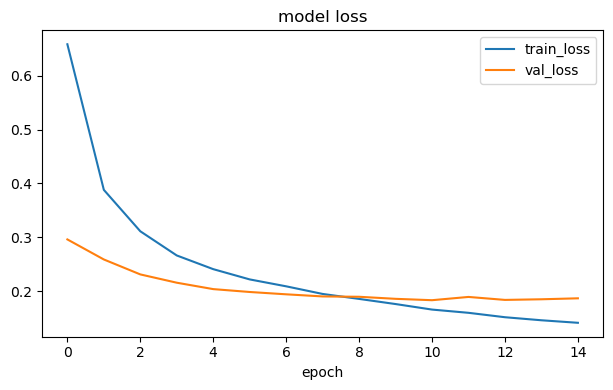

In [50]:
#可视化训练历史情况
plot_train_history(history)

In [51]:
#保存模型
# 保存模型参数到文件
torch.save(trained_model.state_dict(), 'models/word2vec_textCNN5.pth')

In [54]:
# 设定设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载模型的状态字典
# 首先创建一个与原模型架构相同的实例
model = TextCNN(vocab_size=len(vocab),
                embedding_dim=embedding_dim,
                num_filters=128,
                filter_sizes=[3,4],
                num_classes=14,
                dropout=0.2)

# 然后加载状态字典
model.load_state_dict(torch.load('models/word2vec_textCNN5.pth', map_location=device,weights_only=True))
model.to(device)  # 将模型移动到相应的设备上
model.eval()  # 切换到评估模式

TextCNN(
  (embedding): Embedding(5973, 200)
  (convs): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 128, kernel_size=(3, 200), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 200), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=14, bias=True)
)

In [55]:
#构造测试数据集
test_data_file = './data/test_a.csv'
test_data = pd.read_csv(test_data_file,sep='\t')
test_texts = test_data['text'].values
test_texts_as_int_lists = [text_to_int(text, vocab, max_len=900) for text in test_texts]
test_dataset = TextDataset(test_texts_as_int_lists, [0] * len(test_texts_as_int_lists), word_vectors, max_len=900)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [56]:
#预测新数据
def predict(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # 将模型移动到相应的设备
    model.eval()      # 切换到评估模式
    predictions = []
    with torch.no_grad():
        for inputs, _ in dataloader:  # 假设新数据没有标签
            inputs = inputs.to(device) # 将数据移动到相应的设备
            outputs = model(inputs)
            # 对于分类任务，通常会使用softmax函数将输出转换为概率分布，然后选择具有最高概率的类别作为预测结果。直接使用torch.max函数获取每行的最大值及其索引。只关心类别索引（预测标签），所以第二个返回值preds就是需要的结果
            _, preds = torch.max(outputs, 1)
            # # 将预测结果从PyTorch张量转换为NumPy数组，并添加到predictions列表中。.cpu()方法确保即使原始张量位于GPU上，也可以安全地转换为NumPy格式。
            predictions.extend(preds.cpu().numpy())
    return predictions

In [57]:
predictions = predict(model, test_dataloader)

In [58]:
pd.DataFrame(predictions,columns=['label']).to_csv('models/word2vec_textCNN_submit5.csv', index=False)